# Titanic Survival Prediction
## Random Forest Model

This notebook consolidates data preparation, feature engineering,
model training, and evaluation for a Titanic survival prediction model.

The goal is model rigor and reproducibility.

In [56]:
# ============================================
# Environment setup (local execution)
# ============================================

import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [57]:
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.width", 200)

In [58]:
# Define local data directory
DATA_DIR = "../data/raw"

# Optional: list available files (Kaggle-equivalent sanity check)
print("Files in data directory:")
for filename in os.listdir(DATA_DIR):
    print(os.path.join(DATA_DIR, filename))

# Load datasets (paths adapted from Kaggle)
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

print("\nTrain shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Load training data (local path)
train_data = pd.read_csv("../data/raw/train.csv")
train_data.head()

test_data = pd.read_csv("../data/raw/test.csv")
test_data.head()

Files in data directory:
../data/raw\gender_submission.csv
../data/raw\test.csv
../data/raw\train.csv

Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [59]:
train_data.shape

train_data.dtypes

unique_value_counts_train = train_data.nunique()
print(unique_value_counts_train)

missing_value_counts_train = train_data.isnull().sum()
print(missing_value_counts_train)

test_data.shape

unique_value_counts_test = test_data.nunique()
print(unique_value_counts_test)

missing_value_counts_test = test_data.isnull().sum()
print(missing_value_counts_test)

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId    418
Pclass           3
Name           418
Sex              2
Age             79
SibSp            7
Parch            8
Ticket         363
Fare           169
Cabin           76
Embarked         3
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [60]:
# Define a function to perform the data transformations
def transform_data(data):
    
    # Drop 'Name' column
    data.drop(columns=['Name'], inplace=True)
    
    # Convert 'Sex' to 0 for 'male' and 1 for 'female'
    sex_mapping = {'male': 0, 'female': 1}
    data['Sex'] = data['Sex'].map(sex_mapping)
    
    # Fill missing values in 'Age' with 0
    data['Age'] = data['Age'].fillna(0)

    # Map non-missing values to 1
    data['Age'] = data['Age'].apply(lambda x: 1 if x > 0 else x)

    # Create a new feature 'FamSz' by summing 'SibSp' and 'Parch'
    data['FamSz'] = data['SibSp'] + data['Parch']

    # Drop 'Ticket', 'Cabin', 'Fare', 'PassengerId' columns
    data.drop(columns=['Ticket', 'Cabin', 'Fare', 'PassengerId'], inplace=True)

    # Fill missing values in 'Embarked' with mode
    embarked_mode = data['Embarked'].mode()[0]
    data['Embarked'] = data['Embarked'].fillna(embarked_mode)

    # Convert 'Embarked' to numeric values (1, 2, 3)
    embarked_mapping = {'S': 1, 'C': 2, 'Q': 3}
    data['Embarked'] = data['Embarked'].map(embarked_mapping)
    
    return data

In [61]:
# Save PassengerId BEFORE transform_data drops it (for submission output)
test_passenger_ids = test_data["PassengerId"].copy()

# Apply the transformations to both training and testing data
train_data = transform_data(train_data)
test_data = transform_data(test_data)

# Verify the transformations
print(train_data.head())
print(test_data.head())

   Survived  Pclass  Sex  Age  SibSp  Parch  Embarked  FamSz
0         0       3    0  1.0      1      0         1      1
1         1       1    1  1.0      1      0         2      1
2         1       3    1  1.0      0      0         1      0
3         1       1    1  1.0      1      0         1      1
4         0       3    0  1.0      0      0         1      0
   Pclass  Sex  Age  SibSp  Parch  Embarked  FamSz
0       3    0  1.0      0      0         3      0
1       3    1  1.0      1      0         1      1
2       2    0  1.0      0      0         3      0
3       3    0  1.0      0      0         1      0
4       3    1  1.0      1      1         1      2


In [62]:
unique_value_counts_train = train_data.nunique()
print(unique_value_counts_train)

missing_value_counts_train = train_data.isnull().sum()
print(missing_value_counts_train)

unique_value_counts_test = test_data.nunique()
print(unique_value_counts_test)

missing_value_counts_test = test_data.isnull().sum()
print(missing_value_counts_test)

train_data.dtypes

Survived    2
Pclass      3
Sex         2
Age         2
SibSp       7
Parch       7
Embarked    3
FamSz       9
dtype: int64
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
FamSz       0
dtype: int64
Pclass      3
Sex         2
Age         2
SibSp       7
Parch       8
Embarked    3
FamSz       9
dtype: int64
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
FamSz       0
dtype: int64


Survived      int64
Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Embarked      int64
FamSz         int64
dtype: object

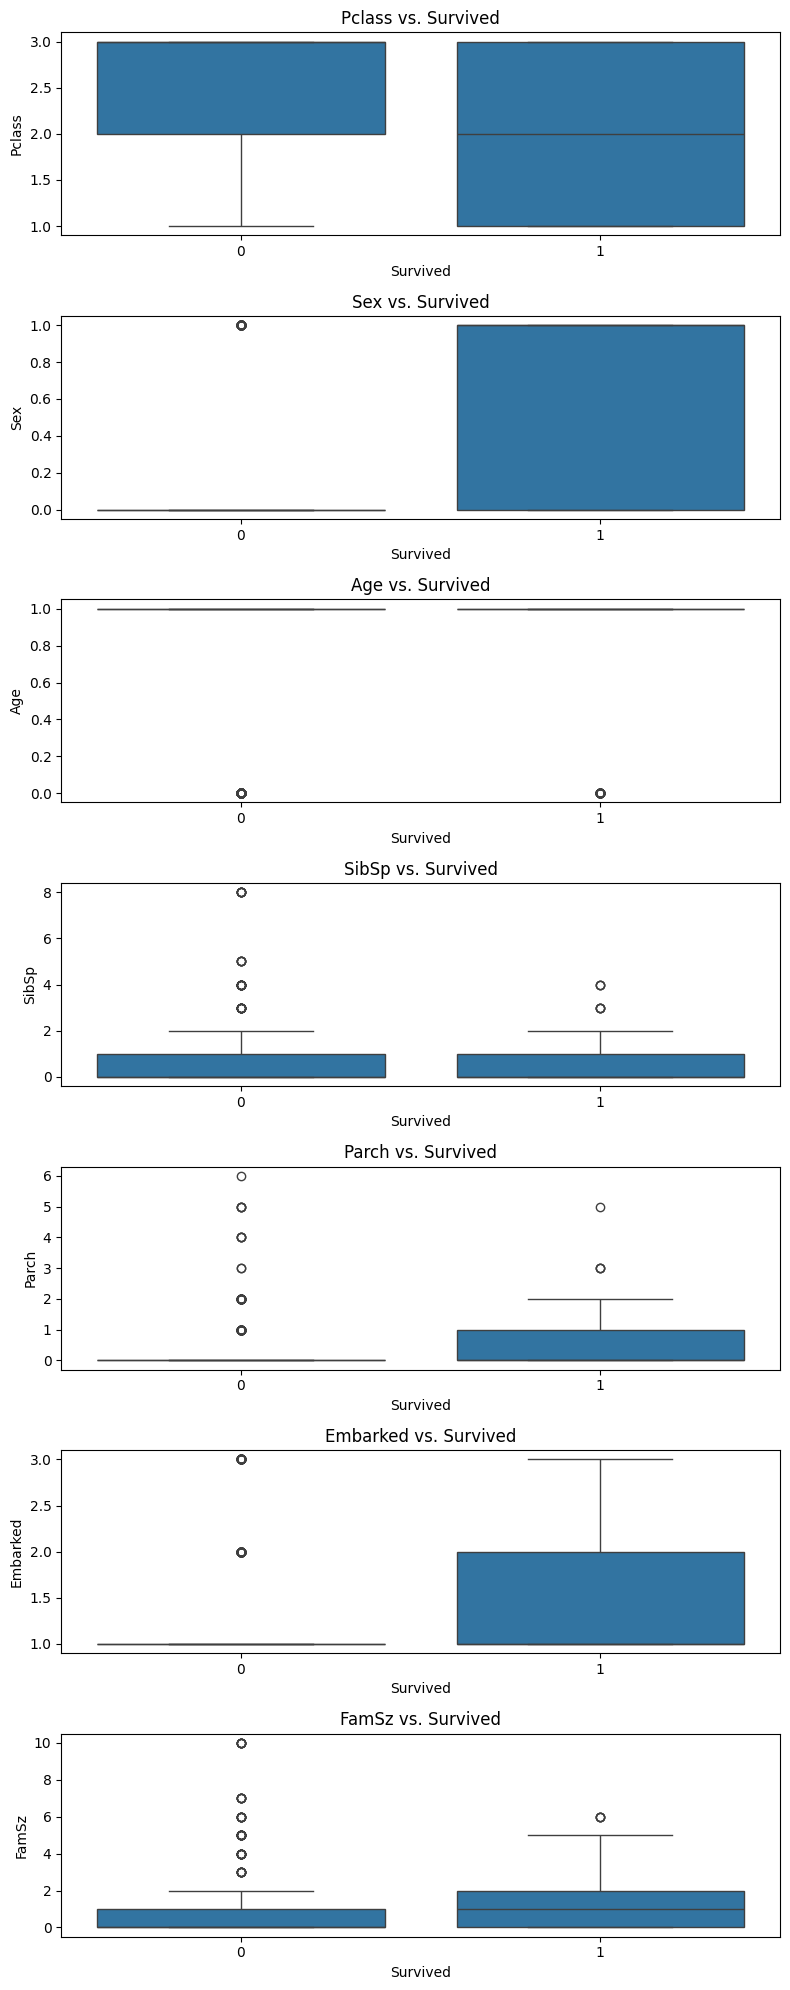

In [63]:
# Define the numeric features you want to plot
numeric_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'FamSz']

# Create a figure with subplots for each feature
fig, axes = plt.subplots(nrows=len(numeric_features), ncols=1, figsize=(8, 20))

# Loop through each feature and create a box plot
for i, feature in enumerate(numeric_features):
    sns.boxplot(x='Survived', y=feature, data=train_data, ax=axes[i])
    axes[i].set_title(f'{feature} vs. Survived')

plt.tight_layout()
plt.show()

In [64]:
# Separate the target variable 'Survived' from the training data
X_train = train_data.drop(columns=['Survived']).copy()
y_train = train_data['Survived'].copy()

# Ensure the test dataset has the same features (excluding 'Survived')
X_test = test_data.copy()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (891, 7)
y_train shape: (891,)
X_test shape: (418, 7)


In [65]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the scaler on your training data
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Convert the NumPy arrays back to DataFrames
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X_test.columns)

In [66]:
# Check the summary statistics of the normalized data
print("Summary Statistics for X_train_normalized:")
print(X_train_normalized_df.describe())
print("\nSummary Statistics for X_test_normalized:")
print(X_test_normalized_df.describe())

Summary Statistics for X_train_normalized:
             Pclass           Sex           Age         SibSp         Parch      Embarked         FamSz
count  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02
mean  -8.772133e-17  3.987333e-17 -3.638441e-17  4.386066e-17  5.382900e-17  1.056643e-16 -3.987333e-18
std    1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00
min   -1.566107e+00 -7.376951e-01 -2.008457e+00 -4.745452e-01 -4.736736e-01 -5.688371e-01 -5.609748e-01
25%   -3.693648e-01 -7.376951e-01  4.978947e-01 -4.745452e-01 -4.736736e-01 -5.688371e-01 -5.609748e-01
50%    8.273772e-01 -7.376951e-01  4.978947e-01 -4.745452e-01 -4.736736e-01 -5.688371e-01 -5.609748e-01
75%    8.273772e-01  1.355574e+00  4.978947e-01  4.327934e-01 -4.736736e-01  1.005181e+00  5.915988e-02
max    8.273772e-01  1.355574e+00  4.978947e-01  6.784163e+00  6.974147e+00  2.579199e+00  5.640372e+00

Summary Statistics f

In [67]:
# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [2, 4, 8, 10, 25, 50, 100],
    'max_depth': [None, 2, 3, 4, 8, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

# Create a Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

In [68]:
# Fit the grid search to your training data
grid_search.fit(X_train_normalized, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Use the best model for prediction and evaluation
y_test_pred_rf = best_model.predict(X_test_normalized)

output = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": y_test_pred_rf
})

output.to_csv('../submissions/rfc_gs.csv', index=False)

print("Your submission was successfully saved!")

Fitting 10 folds for each of 1008 candidates, totalling 10080 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 25}
Your submission was successfully saved!


## Notes

- This model prioritizes stability and cross-validated performance
- No feature leakage is introduced
- This notebook serves as the modeling backbone for
  downstream explainability and interactive applications

In [70]:
# ---- Handshake objects for Hex (no logic changes) ----

hex_model = best_model
hex_scaler = scaler
hex_feature_names = X_train.columns.tolist()